In [7]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from transformers import GPT2TokenizerFast
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import FAISS
from langchain.chains.question_answering import load_qa_chain
from langchain.llms import OpenAI
from langchain.chains import ConversationalRetrievalChain

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [8]:
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')

file_name = './data/sbc-sample.pdf'

In [9]:
# You MUST add your PDF to local files in this notebook (folder icon on left hand side of screen)

# Simple method - Split by pages 
loader = PyPDFLoader(file_name)
pages = loader.load_and_split()
print(pages[0])

# SKIP TO STEP 2 IF YOU'RE USING THIS METHOD
chunks = pages

page_content='1 of 8 Insurance Company 1: Plan Option 1  Coverage Period: 01/01/2013 – 12/31/2013 \nSummary of Benefits and Coverage: What this Plan Covers & What it Costs  Coverage for: Individual + Spouse | Plan Type: PPO \nQuestions:  Call 1-800-[insert] or visit us at www .[insert] . \nIf you aren’t clear about any of the underlined terms used in this form, see the Glossary.  You can view the Glossary \nat www.[insert]  or call 1- 800-[ insert ] to request a copy.   \n This is  only a summary . If you want more detail about you r coverage and costs , you can get the complete terms in the policy or plan \ndocument at www. [insert]  or by calling 1-800-[insert] . \n  \nImportant Questions  Answers  Why this Matters:  \nWhat is the overa ll \ndeductible ? $500 person  /  \n$1,000 family  \nDoesn’t apply to preventive  care  You must pay all the costs up to the deductible  amount before this  plan begins to pay for \ncovered services you use. Check your policy or plan document to see w

In [10]:
# Advanced method - Split by chunk

# Step 1: Convert PDF to text
import textract
doc = textract.process(file_name)

# Step 2: Save to .txt and reopen (helps prevent issues)
with open('./output/sample_health_insurance_policy.txt', 'w') as f:
    f.write(doc.decode('utf-8'))

with open('./output/sample_health_insurance_policy.txt', 'r') as f:
    text = f.read()

# Step 3: Create function to count tokens
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")

def count_tokens(text: str) -> int:
    return len(tokenizer.encode(text))

# Step 4: Split text into chunks
text_splitter = RecursiveCharacterTextSplitter(
    # Set a really small chunk size, just to show.
    chunk_size = 512,
    chunk_overlap  = 24,
    length_function = count_tokens,
)

chunks = text_splitter.create_documents([text])

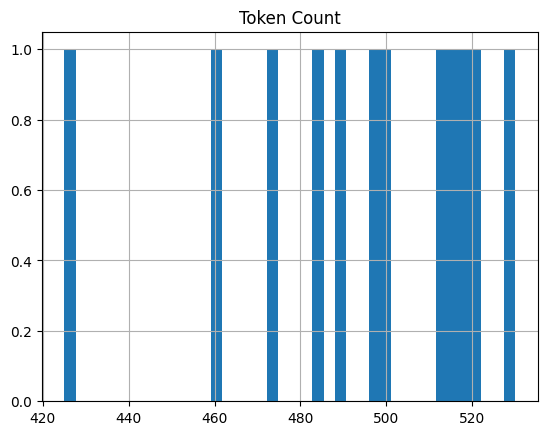

In [11]:
# Quick data visualization to ensure chunking was successful

# Create a list of token counts
token_counts = [count_tokens(chunk.page_content) for chunk in chunks]

# Create a DataFrame from the token counts
df = pd.DataFrame({'Token Count': token_counts})

# Create a histogram of the token count distribution
df.hist(bins=40, )

# Show the plot
plt.show()

In [12]:
# Get embedding model
embeddings = OpenAIEmbeddings()

# Create vector database
db = FAISS.from_documents(chunks, embeddings)

In [13]:
# Check similarity search is working
query = 'What is the overall deductible?'
docs = db.similarity_search(query)
docs[0]

Document(page_content='Insurance Company 1: Plan Option 1 \nCoverage Period: 01/01/2013 – 12/31/2013 \nSummary of Benefits and Coverage: What this Plan Covers & What it Costs  Coverage for: Individual + Spouse | Plan Type: PPO \n\nThis is only a summary. If you want more detail about your coverage and costs, you can get the complete terms in the policy or plan \ndocument at www.[insert] or by calling 1-800-[insert]. \n\n \n\n \n\n \n\nImportant Questions  Answers \n\nWhy this Matters: \n\nWhat is the overall \ndeductible? \n\n$500 person /  \n$1,000 family  \nDoesn’t apply to preventive care  \n\nYou must pay all the costs up to the deductible amount before this plan begins to pay for \ncovered services you use. Check your policy or plan document to see when the deductible \nstarts over (usually, but not always, January 1st). See the chart starting on page 2 for how \nmuch you pay for covered services after you meet the deductible. \n\nAre there other \ndeductibles for specific \nservi

In [14]:
# Create QA chain to integrate similarity search with user queries (answer query from knowledge base)

# chain = load_qa_chain(OpenAI(temperature=0), chain_type="stuff")

# query = 'What is the overall deductible?'
# docs = db.similarity_search(query)

# chain.run(input_documents=docs, question=query)

In [15]:
from IPython.display import display
import ipywidgets as widgets

# Create conversation chain that uses our vectordb as retriver, this also allows for chat history management
qa = ConversationalRetrievalChain.from_llm(OpenAI(temperature=0.1), db.as_retriever())

In [16]:
chat_history = []

def on_submit(_):
    query = input_box.value
    input_box.value = ""
    
    if query.lower() == 'exit':
        print("Thank you for using the State of the Union chatbot!")
        return
    
    result = qa({"question": query, "chat_history": chat_history})
    chat_history.append((query, result['answer']))
    
    display(widgets.HTML(f'<b>User:</b> {query}'))
    display(widgets.HTML(f'<b><font color="blue">Chatbot:</font></b> {result["answer"]}'))

print("Welcome to the Transformers chatbot! Type 'exit' to stop.")

input_box = widgets.Text(placeholder='Please enter your question:')
input_box.continuous_update = False
input_box.observe(on_submit, names='value')
# input_box.on_submit(on_submit)

display(input_box)

Welcome to the Transformers chatbot! Type 'exit' to stop.


Text(value='', continuous_update=False, placeholder='Please enter your question:')